# Partial Dependency Plots

Partial dependence plots show how a feature affects predictions(i.e increase or decrease).It shows the marginal effect of one or two features have on the predicted outcome of a machine learning model. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. 

Marginal effects measure the impact that an instantaneous unit change in one variable has on the outcome variable while all other variables are held constant.

### Possible Questions to ask
By keeping **all the features constant**, How the **prediction** (class probility) will changes if the **total amount spend** on credit card increases/decrease?

![Data](images/example.png)

![Data](images/PDP_plot.png)

# Credit Card customer churn prediction

A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

# Get data

Load data from https://www.kaggle.com/sakshigoyal7/credit-card-customers

# Import Packages

In [5]:
## Data Analysis packages
import pandas as pd
import numpy as np

## Machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report
import xgboost
from xgboost import XGBClassifier

## Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Model Interpretation package
import pdpbox as pdb
from pdpbox import pdp, info_plots

# Check package version
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"PDBbox Version: {pdb.__version__}")
print(f"Xgbbost Version: {xgboost.__version__}")

Pandas Version: 1.1.4
Numpy Version: 1.19.4
scikit-learn Version: 0.23.2
PDBbox Version: 0.2.0
Xgbbost Version: 1.3.0


# Load data

In [6]:
# Data Files
data_file      = '../data/credit_card_customer_churn/BankChurners.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 10127 samples with 21 features.


# Quick data analysis

In [7]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [8]:
data['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

### Correlation Analysis

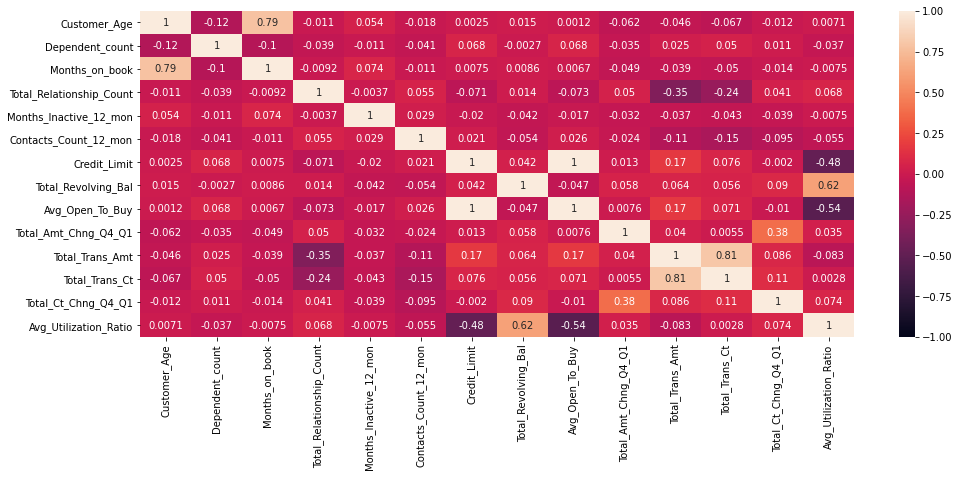

In [9]:
num_cols =['Customer_Age', 'Dependent_count', 'Months_on_book',
           'Total_Relationship_Count', 'Months_Inactive_12_mon',
           'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
           'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

# Increase the size of the heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot=True)

## Prepare data for model training

In [10]:
# Exclude some features from the feature list for model training
exclude_feature = ['CLIENTNUM', 'Avg_Open_To_Buy', 'Attrition_Flag']
# Define Target columns
target = data['Attrition_Flag'].map({"Existing Customer": 0 , "Attrited Customer": 1})

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])

# Xgboost model Training

In [11]:
# Model Training
xgb_clf = XGBClassifier(max_depth = 3, objective='binary:logistic', eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Check training and validation metrics
train_prediction = xgb_clf.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, train_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("=================================")
print(f"Training AUC:{roc_auc}")

val_prediction = xgb_clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, val_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print(f"Validation AUC:{roc_auc}")
print("=================================")

Training AUC:0.9988347678418306
Validation AUC:0.9944069374738433


## Feature Importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

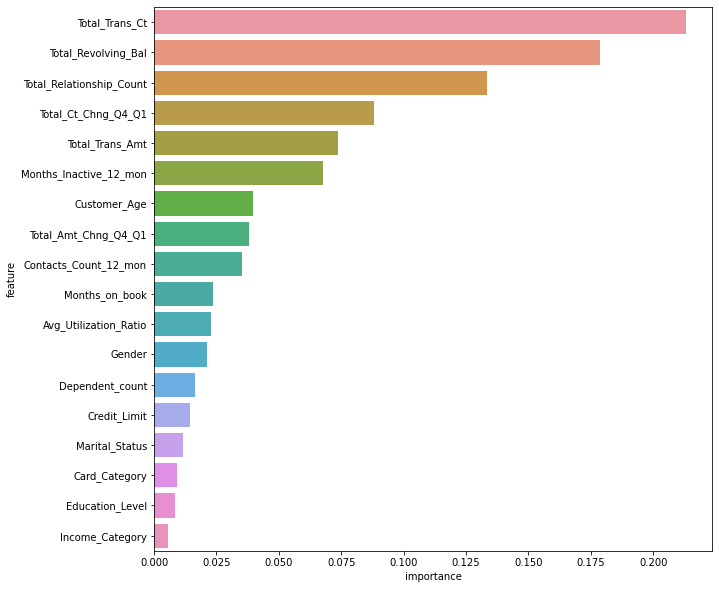

In [12]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = xgb_clf.feature_importances_

feature_importance_df  = feature_importance_df.sort_values('importance', ascending=False).reset_index()
plt.figure(figsize = (10, 10))
sns.barplot(x ='importance', y ='feature', data= feature_importance_df[:20])

## Prediction distribution through some of key features

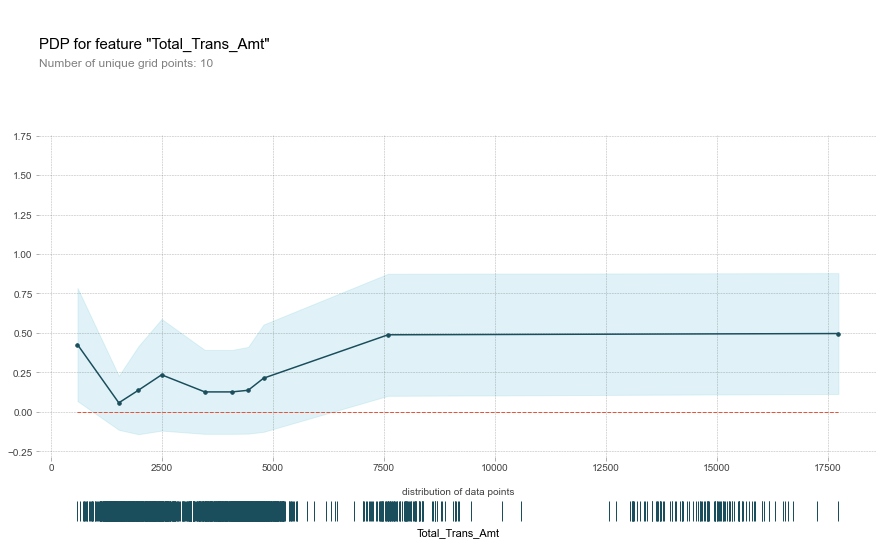

In [119]:
# Controlling for all other features and keep it constant, what impact will Total_Trans_Amt have on customer churn rate? 
pdp_total_trans_amt = pdp.pdp_isolate(
    model=xgb_clf, dataset=X_valid, model_features=X_valid.columns, feature='Total_Trans_Amt'
)

# more info
fig, axes = pdp.pdp_plot(pdp_total_trans_amt, 'Total_Trans_Amt', 
                         plot_lines=False, center=False, 
                         frac_to_plot=0.5, plot_pts_dist=True,
                         show_percentile=False)

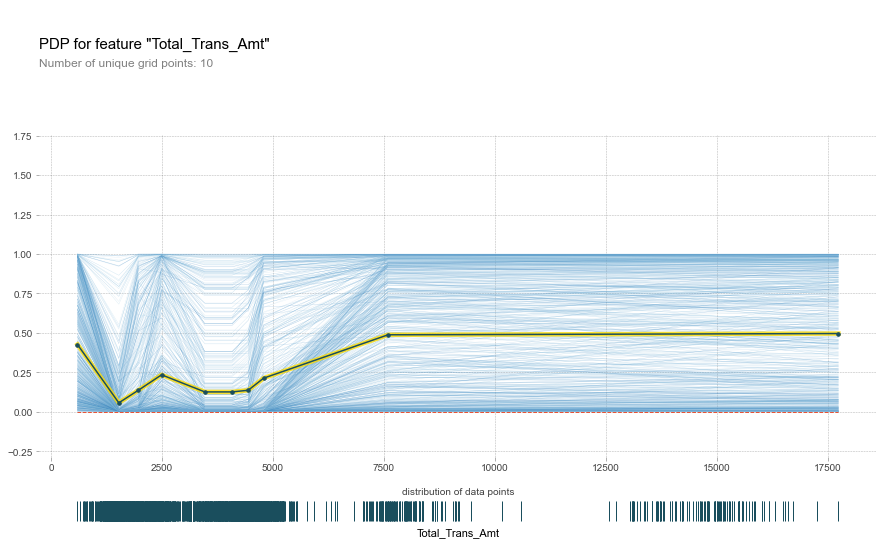

In [121]:
# # Controlling for all other features and keep it constant, what impact will Total_Trans_Amt have on customer churn rate? 
fig, axes = pdp.pdp_plot(pdp_total_trans_amt, 'Total_Trans_Amt',
                         plot_lines=True, center=False, 
                         frac_to_plot=0.5, plot_pts_dist=True, 
                         show_percentile=False)

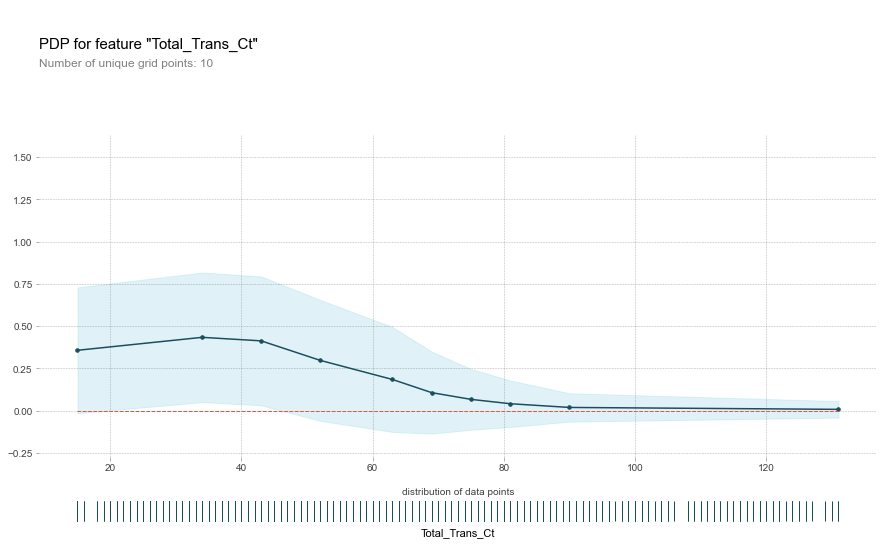

In [55]:
# Controlling for all other features and keep it constant, what impact will Total_Trans_Ct have on customer churn rate? 
pdp_total_trans_ct = pdp.pdp_isolate(
    model=xgb_clf, dataset=X_valid, model_features=X_valid.columns, feature='Total_Trans_Ct'
)

fig, axes = pdp.pdp_plot(pdp_total_trans_ct, 'Total_Trans_Ct', 
                         plot_lines=False, center=False, 
                         frac_to_plot=0.5, plot_pts_dist=True,
                         show_percentile=False)

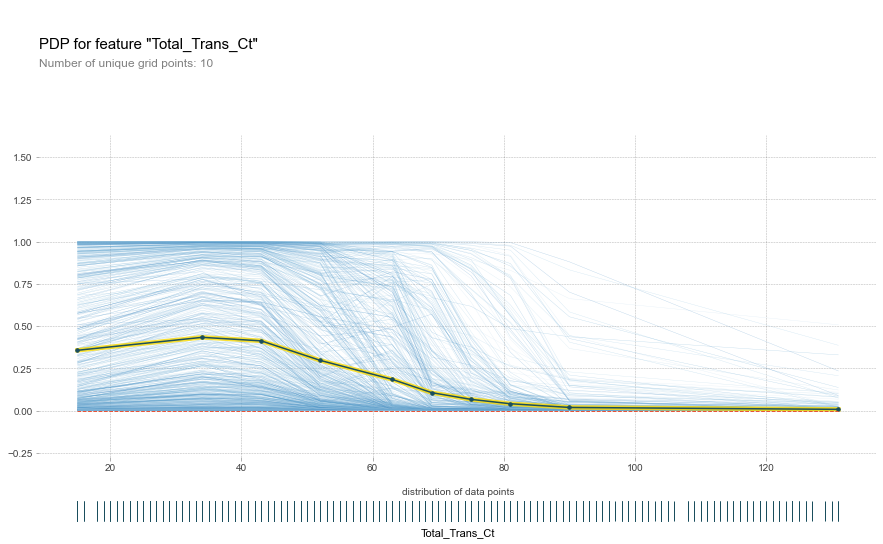

In [118]:
# Controlling for all other features and keep it constant, what impact will Total_Trans_Ct have on customer churn rate? 
fig, axes = pdp.pdp_plot(pdp_total_trans_ct, 'Total_Trans_Ct',
                         plot_lines=True, center=False, 
                         frac_to_plot=0.5, plot_pts_dist=True, 
                         show_percentile=False)

## Prediction distribution through some of the key features Interaction

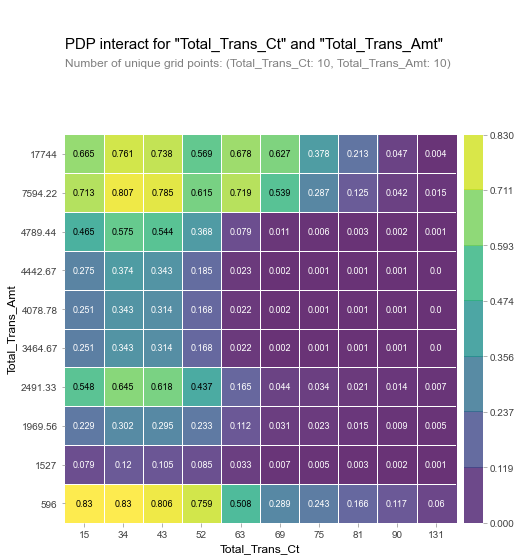

In [13]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['Total_Trans_Ct', 'Total_Trans_Amt']
interaction_1  =  pdp.pdp_interact(model=xgb_clf, dataset=X_valid, model_features=X_valid.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=interaction_1, feature_names=features_to_plot, plot_type='grid')
plt.show()

### Disadvantages

1) The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.

2) Heterogeneous effects of features might be hidden because PD plots only show the average marginal effects and might lead to incorrect interpretation of the feature impact on prediction.

Suppose that for a feature half your data points have a positive association with the prediction -- the larger the feature value the larger the prediction -- and the other half has a negative association -- the smaller the feature value the larger the prediction. The PD curve could be a horizontal line, since the effects of both halves of the dataset could cancel each other out. You then conclude that the feature has no effect on the prediction. 

## References

https://christophm.github.io/interpretable-ml-book/

https://www.alexpghayes.com/blog/understanding-multinomial-regression-with-partial-dependence-plots/

https://github.com/SauceCat/PDPbox